# Programa auxiliar para generar más variedad de imágenes aplicando DataAugmentation
Nota: las imágenes generadas tendrán el prefijo "DA" para poder ser identificadas.

In [1]:
#@title Librerías a usar
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image

from matplotlib import pyplot as plt
#import matplotlib.pyplot as plt


import random

print("\nLibrerías importadas")


Librerías importadas


In [2]:
#@title Acceder al Drive

import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoML/imagenes/ANIMALES' #@param {type:"string"}
path_entrenamiento = '/train'  #@param {type:"string"}
path_prueba = '/test'  #@param {type:"string"}


# define configuración de los directorios
imagPath_train = path + path_entrenamiento
imagPath_test = path + path_prueba


Mounted at /content/gdrive


> Para Entrenamiento: 
 procesando  gdrive/My Drive/IA/demoML/imagenes/ANIMALES/train : 
  --  gdrive/My Drive/IA/demoML/imagenes/ANIMALES/train/gato : tiene  24  imágenes.
  --  gdrive/My Drive/IA/demoML/imagenes/ANIMALES/train/tigre : tiene  24  imágenes.
  --  gdrive/My Drive/IA/demoML/imagenes/ANIMALES/train/lobo : tiene  24  imágenes.
  --  gdrive/My Drive/IA/demoML/imagenes/ANIMALES/train/zorro : tiene  24  imágenes.
  --  gdrive/My Drive/IA/demoML/imagenes/ANIMALES/train/perro : tiene  24  imágenes.
  --  gdrive/My Drive/IA/demoML/imagenes/ANIMALES/train/leon : tiene  24  imágenes.
- Clases cargadas:  6
- Imágenes cargadas:  144


> Para Prueba: 
 procesando  gdrive/My Drive/IA/demoML/imagenes/ANIMALES/test : 
  --  gdrive/My Drive/IA/demoML/imagenes/ANIMALES/test/gato : tiene  6  imágenes.
  --  gdrive/My Drive/IA/demoML/imagenes/ANIMALES/test/tigre : tiene  6  imágenes.
  --  gdrive/My Drive/IA/demoML/imagenes/ANIMALES/test/lobo : tiene  6  imágenes.
  --  gdrive/My Drive/IA/d

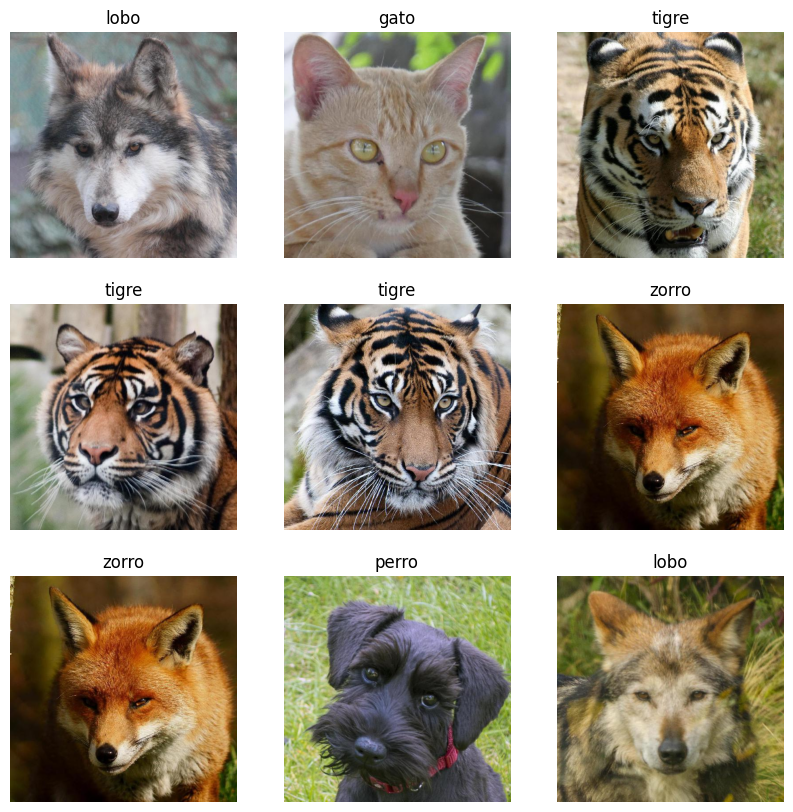

In [3]:
#@title Cargar imágenes

# funciones auxiliares
def contarImagenesDrive(imagPath):
  print(" procesando ", imagPath, ": ")
  # procesa los subdirectorios con las imágenes
  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:
    auxiPath = imagPath + '/' + each_dir
    # obtiene la cantidad de imágenes disponibles
    if os.path.isdir(auxiPath):
      cantImagDir = len(os.listdir( auxiPath ))
      print("  -- ", auxiPath, ": tiene ", cantImagDir, " imágenes.")


def mostrarEjemplosImagenes(images, clases, cantMostrar=9):
   if len(images)==0:
     return
   plt.figure(figsize=(10, 10))
   nCols = 3
   nRows = cantMostrar//nCols
   for i in range(cantMostrar):
      # elige al azar
      posIm = random.randint(1, len(images))
      im = images[posIm-1]
      cl = clases[posIm-1]
      # la muestra
      ax = plt.subplot(nRows, nCols, i + 1)
      plt.imshow(im.astype("uint8"))
      plt.title(cl)
      plt.axis("off")


# define función para cargar las imágenes
# nota: no se restringe el tamaño de las imágenes
def cargarImagenes(imagPath):
  classes_ori = []
  images_ori = []
  esDA_ori = []

  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:

      auxiPath = imagPath + '/' + each_dir
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:

            esImagDA = (each_imagFN[:2].lower() == 'da')

            if (not esImagDA):

                # abre la imagen
                imag = Image.open(auxiPath + "/" + each_imagFN)

                # ajusta tipo imagen
                tipoImage = 'RGB'
                imag = imag.convert(tipoImage)

                # transforma a un vector de nros
                arImag = np.array(imag).astype(np.uint8)

                # agrega a los vectores
                classes_ori.append( each_dir )
                images_ori.append( arImag )
                esDA_ori.append( esImagDA )

  return classes_ori, images_ori, esDA_ori, tipoImage

# carga las imagenes de entrenamiento
print("> Para Entrenamiento: ")
contarImagenesDrive(imagPath_train)
classes_train, images_train, esDAimag_train, tipoImage_train = cargarImagenes(imagPath_train)
da_images_train = []
da_classes_train = []

print("- Clases cargadas: ", len(np.unique(classes_train)))
print("- Imágenes cargadas: ", len(classes_train))

# carga las imagenes de prueba
print("\n\n> Para Prueba: ")
contarImagenesDrive(imagPath_test)
classes_test, images_test, esDAimag_test, tipoImage_test = cargarImagenes(imagPath_test)
print("- Clases cargadas: ", len(np.unique(classes_test)))
print("- Imágenes cargadas: ", len(images_test))
da_images_test = []
da_classes_test = []

if len(classes_train)>0:
  print("\n- Ejemplos de entrenamiento ", images_train[0].shape, ": ")
  mostrarEjemplosImagenes(images_train, classes_train)


In [4]:
#@title Configuración para Image Augmentation

#@markdown Ajuste Tamaño:
da_NewSize_operacion = "-" #@param ["Resize", "Center Crop", "Random Crop", "-"]
da_NewSize_height = 100 #@param {type:"integer"}
da_NewSize_width = 100 #@param {type:"integer"}

#@markdown Zoom:
da_RandomZoom_factor = 0.4 #@param {type:"number"}

#@markdown Giros y Rotación:
da_RandomFlip_Horizontal = True #@param {type:"boolean"}
da_RandomFlip_Vertical = True #@param {type:"boolean"}
da_RandomRotation_factor = 0.1 #@param {type:"number"}
da_RandomTranslation_Horizontal_factor = 0.2 #@param {type:"number"}
da_RandomTranslation_Vertical_factor = 0.2 #@param {type:"number"}

#@markdown Constrate y Brillo:
da_RandomContrast_factor = 0.5 #@param {type:"number"}
da_RandomBrightness_factor = 0.5 #@param {type:"number"}

# capas de data augmentation (solo para training)
daLayers_modelo = []

if (da_NewSize_operacion!="-" ) and (da_NewSize_height>1) and (da_NewSize_width>1):
  if da_NewSize_operacion == "Center Crop":
       daLayers_modelo.append( tf.keras.layers.CenterCrop(height=da_NewSize_height, width=da_NewSize_width) )
  elif da_NewSize_operacion == "Random Crop":
       daLayers_modelo.append( tf.keras.layers.RandomCrop(height=da_NewSize_height, width=da_NewSize_width) )
  else: # Resize
      daLayers_modelo.append( tf.keras.layers.Resizing( height=da_NewSize_height, width=da_NewSize_width) )

if da_RandomFlip_Horizontal or da_RandomFlip_Vertical:
    if da_RandomFlip_Horizontal:
      modeDAFlip = "horizontal"
      if da_RandomFlip_Vertical:
        modeDAFlip = modeDAFlip + "_and_vertical"
    else:
      modeDAFlip = "vertical"
    daLayers_modelo.append( tf.keras.layers.RandomFlip(mode=modeDAFlip, seed=None, name="da_rndFlip_"+modeDAFlip) )

if (da_RandomTranslation_Horizontal_factor != 0.0) or (da_RandomTranslation_Vertical_factor != 0.0):
  daLayers_modelo.append( tf.keras.layers.RandomTranslation(height_factor=da_RandomTranslation_Vertical_factor/100, width_factor=da_RandomTranslation_Horizontal_factor, name="da_rndTranslation", fill_mode="nearest") )

if da_RandomRotation_factor != 0.0:
    daLayers_modelo.append( tf.keras.layers.RandomRotation(factor=da_RandomRotation_factor, name="da_rndRotation", fill_mode="nearest") )

if da_RandomZoom_factor != 0.0:
  daLayers_modelo.append( tf.keras.layers.RandomZoom(height_factor=da_RandomZoom_factor, name="da_rndZoom", fill_mode="nearest") )

if da_RandomContrast_factor != 0.0:
  daLayers_modelo.append( tf.keras.layers.RandomContrast(factor=da_RandomContrast_factor, name="da_rndContrast") )

if da_RandomBrightness_factor != 0.0:
  daLayers_modelo.append( tf.keras.layers.RandomBrightness(factor=da_RandomBrightness_factor, name="da_rndBrightness") )

# aplica DA a una lista de imágenes
def aplicarDAList(images, classes, da_images, da_clases):
  if len(images)==0:
    print("No hay imágenes para aplicar Image Augmentation!")
    return
  print("Cantidad de imágenes con Image Augmentation antes: ", len(da_images))
  for im, cl in zip(images, classes):
    # aplica todas las capas
    da_images.append( aplicarDA(daLayers_modelo, im) )
    da_clases.append( cl )
  print("Cantidad de imágenes con Image Augmentation luego: ", len(da_images))

# aplica todas las capas del modelo sobre la imagen
def aplicarDA(model, im):
    for da_lay in model:
        im = da_lay(im)
    return im.numpy()

# Muestra images and augmentations
cantCapasDA = len(daLayers_modelo) + 2
if cantCapasDA <= 2:
  print("No se aplican capas de Image Augmentation.")
else:
  print("Configuración definida.\n")
  print("Ejemplo de posibles aplicaciones:")
  fig, ax = plt.subplots(cantCapasDA, 5, figsize=(15,cantCapasDA*3))
  j = 0
  for j in range(5):
    # toma al azar las imágenes a mostrar
    posIm = random.randint(1, len(images_train))
    im = images_train[posIm-1]

    # muestra imagen original
    ax[0][j].imshow((im.astype("uint8")))
    if j == 0:
      ax[0][j].set_title("original")
    ax[0][j].axis('off')

    # muestra imagen con aplicación de capa
    i = 1
    for da_lay in daLayers_modelo:
            ax[i][j].imshow(da_lay( im/1.0 ).numpy().astype("uint8"))
            if j == 0:
              ax[i][j].set_title("- sólo capa " + da_lay.name)
            ax[i][j].axis('off')
            i = i + 1

    # aplica todas las capas
    im = aplicarDA(daLayers_modelo, im)

    ax[i][j].imshow(im.astype("uint8"))
    if j == 0:
      ax[i][j].set_title("* TODAS LAS CAPAS *")
    ax[i][j].axis('off')

    j = j + 1

  plt.show()

Output hidden; open in https://colab.research.google.com to view.

Cantidad de imágenes con Image Augmentation antes:  0
Cantidad de imágenes con Image Augmentation luego:  144

Ejemplos: 


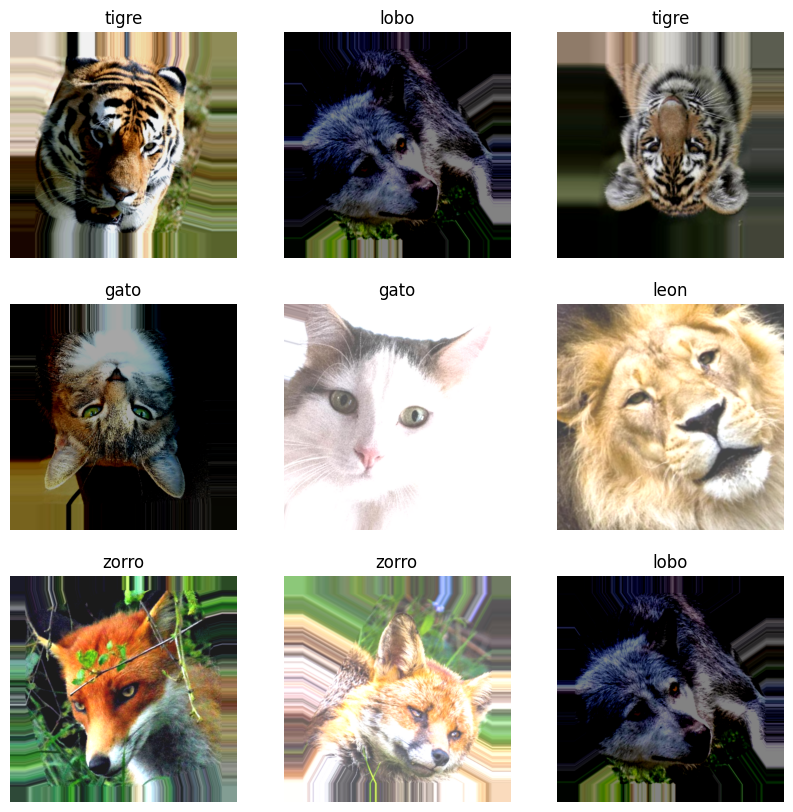

In [5]:
#@title Aplicar configuración sobre imágenes de Entrenamiento

if daLayers_modelo is None or len(daLayers_modelo) == 0:
  print("No se ha definido ninguna capa para Image Augmentation.")

else:
  # aplica DA
  aplicarDAList(images_train, classes_train, da_images_train, da_classes_train)
  # muestra ejemplos
  print("\nEjemplos: ")
  mostrarEjemplosImagenes(da_images_train, da_classes_train)


Cantidad de imágenes con Image Augmentation antes:  0
Cantidad de imágenes con Image Augmentation luego:  36

Ejemplos: 


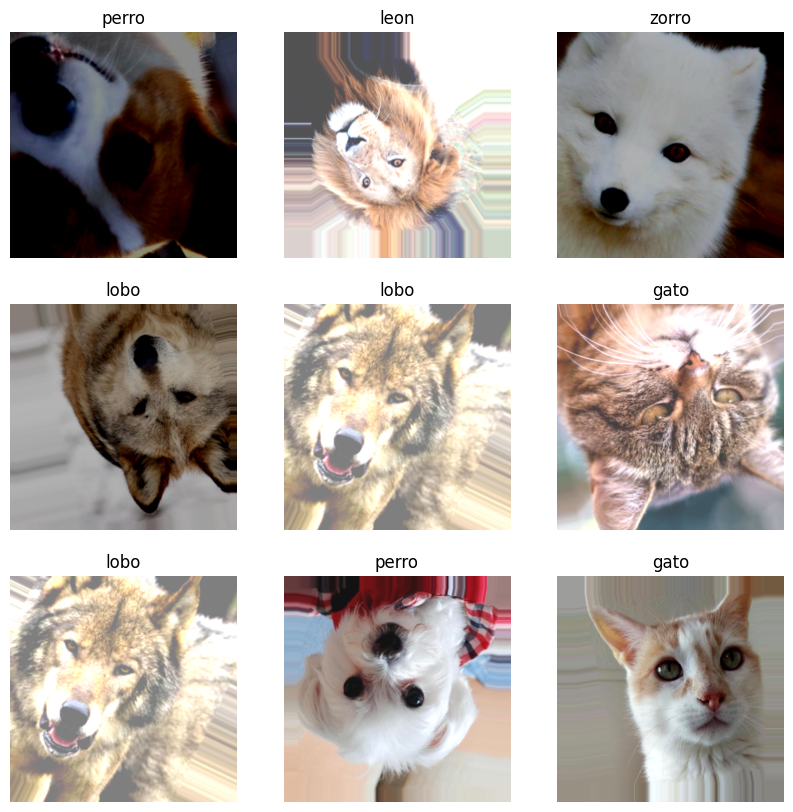

In [6]:
#@title Aplicar configuración sobre imágenes de Prueba

if daLayers_modelo is None or len(daLayers_modelo) == 0:
  print("No se ha definido ninguna capa para Image Augmentation.")
else:
  # aplica DA
  aplicarDAList(images_test, classes_test, da_images_test, da_classes_test)
  # muestra ejemplos
  print("\nEjemplos: ")
  mostrarEjemplosImagenes(da_images_test, da_classes_test)

In [7]:
#@title Grabar las imágenes generadas con Image Augmentation
import datetime

confirmar_grabar_imagenes = False #@param{type:"boolean"}

def grabarImagenes(imagPath, da_image, da_classes):
  c = 0
  for im, cl in zip(da_image, da_classes):
    fname = imagPath + "/" + cl + "/" + "DA_im_" + str(datetime.datetime.now().date()).replace('-', '') + '_' + str(datetime.datetime.now().time()).replace(':', '').replace('.', '_') + ".jpg"
    tf.keras.utils.save_img(fname, im)
    c = c + 1
  print("Se han grabado", c, "nuevas imágenes en ", imagPath)

if confirmar_grabar_imagenes:

  # graba las de entrenamiento
  grabarImagenes(imagPath_train, da_images_train, da_classes_train)

  # graba las de prueba
  grabarImagenes(imagPath_test, da_images_test, da_classes_test)

else:
  print("Imágenes no grabadas.")

Imágenes no grabadas.


In [ ]:

#@title Fuerza actualización del drive (sino no aparecen los nuevos archivos)
drive.flush_and_unmount()
drive.mount('/content/gdrive', force_remount=True)
print("Drive actualizado.")

# muestra cantidad de imágenes
print("\nNuevas cantidades: ")
contarImagenesDrive(imagPath_train)
contarImagenesDrive(imagPath_test)
